# Imports

In [133]:
from collections import defaultdict
from operator import itemgetter
import random

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import scipy
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

<br><br>

# Paths

In [2]:
base_directory_path = ''    # Update this to your directory path
seeds_path        = base_directory_path + '/gathered_seeds.json'
google_model_path = base_directory_path + '/GoogleNews-vectors-negative300.bin'

<br><br>

# General Functions

In [3]:
def sort_by_mean(df, by, column, rot=0):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.mean().sort_values(ascending=False)
    return meds

<br><br>

# Load seeds

In [4]:
seeds_df = pd.read_json(seeds_path)

In [5]:
len(seeds_df.index)  

178

In [6]:
seeds_df.sample(5)

,Category,Seeds,Source / Justification,Source Categories,Used in Paper,Link,Seeds ID
23,female 2,"['sister', 'mother', 'aunt', 'grandmother', 'd...",Nosek at al. (2002),borrowed-from-social-sciences,Semantics derived automatically from language ...,https://dataverse.harvard.edu/dataset.xhtml?pe...,female_2-Caliskan_et_al_2017
67,male pairs,"['he', 'son', 'his', 'him', 'father', 'man', '...","""noun and pronoun pairs""",curated,Word Embeddings Quantify 100 Years of Gender a...,https://github.com/nikhgarg/EmbeddingDynamicSt...,male_pairs-Garg_et_al_2018
112,male,"['man', 'men', 'him', 'his', 'he']",The U.S. Equal Employment Opportunity Commissi...,corpus-derived,Social Bias in Elicited Natural Language Infer...,https://github.com/cjmay/snli-ethics,male-Rudinger_et_al_2017
131,feminine,"['cute', 'gown', 'haircut', 'slimming', 'lacy'...","""...to generate Empath’s category names and se...","crowd-sourced, curated, lexical-resources",Empath: Understanding Topic Signals in Large-S...,https://github.com/Ejhfast/empath-client,feminine-Fast_et_al_2016
81,occupations,"['banker', 'carpenter', 'doctor', 'engineer', ...","In the survey, respondents were asked to rate ...","crowd-sourced, curated",The Geometry of Culture: Analyzing Meaning thr...,None,occupations-Kozlowski_et_al_2019


<br><br>

# PCA Methods

[Man is to computer programmer as woman is to homemaker? Debiasing word embeddings](https://dl.acm.org/doi/abs/10.5555/3157382.3157584)  
Bolukbasi et al., 2016

Run PCA on a difference matrix. Remember to center the vectors (or [standardize](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)) or your results won't look right.

In [128]:
def get_difference_matrix(model, pairs):
    
    M = []
    
    for word1, word2 in pairs:
        
        if word1 in model.wv.vocab and word2 in model.wv.vocab:
        
            a = model.wv[word1]/np.linalg.norm(model.wv[word1], ord=2)
            b = model.wv[word2]/np.linalg.norm(model.wv[word2], ord=2)

            d = a - b
            M.append(d)
            
            e = -(a - b)
            M.append(e)

    M = np.array(M)
    M = (M - np.mean(M)) / np.std(M)

    return M


def run_pca(model, seed_pairs):
    difference_matrix = get_difference_matrix(model, seed_pairs)
    try:
        pca = PCA(n_components=len(seed_pairs)).fit(difference_matrix)
        return pca.explained_variance_ratio_, pca.components_[0], pca.components_[1]
    except ValueError:
        return [], []


def plot_explained_variance(explained_variance_ratios, plot_path=None):

    data_dicts = []
    for i, _ratio in enumerate(explained_variance_ratios):
        data_dicts.append({'Component': str(i+1),
                           'Explained Variance Ratio': _ratio})
    data_df = pd.DataFrame(data_dicts)

    plt.figure(figsize=(5, 2.5))
    sns.set(style='ticks', font_scale=1.2)
    sns.barplot(data=data_df,
                x='Component',
                y='Explained Variance Ratio',
                ci='sd',
                errwidth=1, 
                capsize=0.3,
                color='skyblue',
                order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.ylabel('Explained Variance')
    sns.despine()

    if plot_path:
        plt.savefig(plot_path, bbox_inches='tight')
    plt.show()

<br><br>

# WEAT Methods

[Semantics derived automatically from language corpora contain human-like biases](https://science.sciencemag.org/content/356/6334/183)   
Caliskan et al., 2017

X and Y are the target words, e.g. `X = [programmer, scientist]` and `Y = [nurse, teacher]`.  
A and B are the attribute words, e.g. `A = [man, male]` and `B = [woman, female]`.  

The null hypothesis is that there is no difference between the two sets of target words in terms of their relative similarity to the two sets of attribute words. 

The permutation test measures the (un)likelihood of the null hypothesis by computing the probability that a random permutation of the attribute words would produce the observed (or greater) difference in sample means.

In [8]:
def get_s2(w, A, B, model):
    similarities_a = [1-scipy.spatial.distance.cosine(model.wv[w], model.wv[a]) 
                      for a in A 
                      if w in model.wv.vocab and a in model.wv.vocab]
    similarities_b = [1-scipy.spatial.distance.cosine(model.wv[w], model.wv[b]) 
                      for b in B
                      if w in model.wv.vocab and b in model.wv.vocab]
    if similarities_a and similarities_b:
        return np.mean(similarities_a) - np.mean(similarities_b)
    return 0


def get_s1(X, Y, A, B, model):
    return sum([get_s2(x, A, B, model) for x in X]) - sum([get_s2(y, A, B, model) for y in Y])


def get_permutation_test(X, Y, A, B, model, test_statistic):
    success_count = 0
    count = 0
    for _ in range(0, 100):
        Z = X+Y
        random.shuffle(Z)
        M = Z[:int(len(Z)/2)]
        N = Z[-(int(len(Z)/2)):]
        if get_s1(M, N, A, B, model) > test_statistic:
            success_count += 1
        count += 1
    return success_count / float(count)

<br><br>

# Coherence

Tests the rank of the seed terms when projected onto the bias subspace; ideally, they should be far apart from each other.

In [9]:
def test_coherence_of_sorted_vocab(g, model, seeds1, seeds2):

    word_similarity_dict = {}
    for _word in model.wv.vocab:
        _similarity = 1-scipy.spatial.distance.cosine(model.wv[_word], g)
        word_similarity_dict[_word] = _similarity

    sorted_vocab = [_word for _word, _similarity in sorted(word_similarity_dict.items(), key=lambda x: x[1])]
    word_index_dict = {w: i for i, w in enumerate(sorted_vocab)}
    word_rank_dict = {w: i/float(len(word_index_dict)) for w, i in word_index_dict.items()}

    ranks1 = [word_rank_dict[s] for s in seeds1]
    ranks2 = [word_rank_dict[s] for s in seeds2]

    return abs(np.mean(ranks1) - np.mean(ranks2))

def print_sorted_vocab(g, vocab, model, threshold=5):

    word_similarity_dict = {}
    for _word in vocab:
        if _word in model.wv.vocab and model.wv.vocab[_word].count >= threshold:
            word_similarity_dict[_word] = 1 - scipy.spatial.distance.cosine(model.wv[_word], g)

    if len(word_similarity_dict) >= 200:
        for _word, _similarity in sorted(word_similarity_dict.items(), key=itemgetter(1))[:100]:
            print(_similarity, '\t', _word)
        print('...')  
        for _word, _similarity in sorted(word_similarity_dict.items(), key=itemgetter(1))[-100:]:
            print(_similarity, '\t', _word)
    else:
        for _word, _similarity in sorted(word_similarity_dict.items(), key=itemgetter(1)):
            print(_similarity, '\t', _word)

<br><br>

# Load pre-trained model

You can download the pretrained word2vec model from [Google](https://code.google.com/archive/p/word2vec/).

In [124]:
google_model = KeyedVectors.load_word2vec_format(google_model_path, binary=True) 
google_model.init_sims(replace=True)

<br><br>

# Plot gender categories

['woman', 'girl', 'she', 'mother', 'daugher', 'gal', 'female', 'her', 'herself', 'Mary']
['man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his', 'himself', 'John']


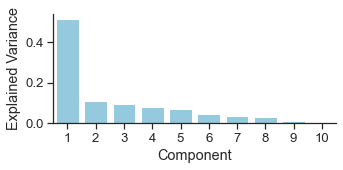

In [131]:
target_seeds_1 = ['woman', 'girl', 'she', 'mother', 'daugher', 'gal', 'female', 'her', 'herself', 'Mary']
target_seeds_2 = ['man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his', 'himself', 'John']

print([s for s in target_seeds_1 if s in google_model])
print([s for s in target_seeds_2 if s in google_model])

explained_variance_ratios_a, component1_a, component2_a = run_pca(google_model, list(zip(target_seeds_1, target_seeds_2)))
plot_explained_variance(explained_variance_ratios_a)

['female', 'herself', 'Mary', 'girl', 'mother', 'her', 'she', 'daugher', 'woman', 'gal']
['John', 'son', 'he', 'guy', 'himself', 'man', 'father', 'male', 'boy', 'his']


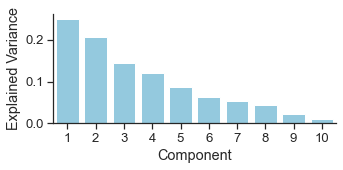

In [132]:
random.shuffle(target_seeds_1)
random.shuffle(target_seeds_2)

print([s for s in target_seeds_1 if s in google_model])
print([s for s in target_seeds_2 if s in google_model])

explained_variance_ratios_a, component1_a, component2_a = run_pca(google_model, list(zip(target_seeds_1, target_seeds_2)))
plot_explained_variance(explained_variance_ratios_a)

<br><br>

# Plot Goodreads example

In [110]:
def get_similarity(model, terms1, terms2):
    similarities = []
    for t1 in terms2:
        for t2 in terms2:
            similarities.append(1 - scipy.spatial.distance.cosine(model.wv[t1], model.wv[t2]))
    return np.mean(similarities)

def get_average_vector(model, tokens):
    word_vectors = [model.wv[w] for w in tokens if w in model.wv.vocab]
    text_vector = np.average(word_vectors, axis=0)
    text_vector /= np.linalg.norm(text_vector, ord=2)
    return text_vector
    
def create_seeds_id(row):
    return '_'.join(row['Category'].split()) + '-' + '_'.join(row['Used in Paper'].split('(')[-1].replace(')', '').replace(',', '').replace('.', '').strip().split())

In [103]:
seeds_df['Seeds ID'] = seeds_df.apply(lambda row: create_seeds_id(row), axis=1)

print(len(seeds_df.index))
seeds_df.sample(5)

178


,Category,Seeds,Source / Justification,Source Categories,Used in Paper,Link,Seeds ID
97,career words,"[executive, management, professional, corpo-, ...",All word lists are taken from Caliskan et al. ...,prior-work,Lipstick on a Pig: Debiasing Methods Cover up ...,None,career_words-Gonen_&_Goldberg_2019
9,african american names market discrimination,"[Kareem, Darnell, Tyrone, Hakim, Jamal, Leroy,...",Bertrand and Mullainathan (2004) (low frequenc...,borrowed-from-social-sciences,Semantics derived automatically from language ...,https://dataverse.harvard.edu/dataset.xhtml?pe...,african_american_names_market_discrimination-C...
137,male plural,"[men, boys, fathers, sons, brothers, husbands,...",None,corpus-derived,Unsupervised Discovery of Gendered Language th...,None,male_plural-Hoyle_et_al_2019
12,male names 1,"[John, Paul, Mike, Kevin, Steve, Greg, Jeff, B...",Nosek at al. (2002),borrowed-from-social-sciences,Semantics derived automatically from language ...,https://dataverse.harvard.edu/dataset.xhtml?pe...,male_names_1-Caliskan_et_al_2017
109,male stereotype words,"[researcher, lawyer, developer, architect, den...",To study the quality of the gender information...,lexical-resources,Learning gender-neutral word embeddings (Zhao ...,https://github.com/uclanlp/gn_glove,male_stereotype_words-Zhao_et_al_2018


Load the romance and history models. You should train these separately using gensim and the Goodreads data provided by the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home).

In [104]:
romance_model_path = base_directory_path + '/romance.word2vec.model' # 
history_model_path = base_directory_path + '/history.word2vec.model'

romance_model = KeyedVectors.load(romance_model_path, mmap='r')
history_model = KeyedVectors.load(history_model_path, mmap='r')

In [105]:
paper_category_seeds_dict = defaultdict(lambda: defaultdict(dict))
for i, _row in seeds_df.iterrows():
    if not _row['Category'] in paper_category_seeds_dict[_row['Used in Paper']]:
        paper_category_seeds_dict[_row['Used in Paper']][_row['Category']] = _row
    else:
        print('Collision!', _row['Category'])
print(len(paper_category_seeds_dict))

18


In [106]:
pleasantness_seeds = ['joy', 'love', 'peace', 'wonderful', 'pleasure', 'friend', 'laughter', 'happy']
unpleasantness_seeds = ['agony', 'terrible', 'horrible', 'nasty', 'evil', 'war', 'awful', 'failure']

In [107]:
unpleasant_vector_romance = get_average_vector(romance_model, unpleasantness_seeds)
pleasant_vector_romance = get_average_vector(romance_model, pleasantness_seeds)

unpleasant_vector_history = get_average_vector(history_model, unpleasantness_seeds)
pleasant_vector_history = get_average_vector(history_model, pleasantness_seeds)

In [108]:
dicts_to_plot = []

for _paper, _category_seeds_dict in paper_category_seeds_dict.items():
    for _category, _seeds_dict in _category_seeds_dict.items():
        
        if len(_seeds_dict['Seeds']) < 30 and ('female' in _category or 'male' in _category):

            print(_category)

            # FORMAT THE SEEDS FOR THE Y-AXIS LABELS
            _seeds = ', '.join([s for s in _seeds_dict['Seeds'] if s in romance_model.wv and s in history_model])   # Instead include if only at least one model 
            if len(_seeds.split()) > 5:
                _seeds = ' '.join(_seeds.split()[:5]) + '...'
            _seeds += '\n(' + ' '.join(_seeds_dict['Seeds ID'].split('-')[-1].split('_')) + ')'

            # CHECK WHICH CATEGORY FOR THE SEEDS
            if 'female' in _category:
                _label = 'female'
            elif 'male' in _category:
                _label = 'male'

            # GET SIMILARITIES FOR ROMANCE AND HISTORY
            for _seed in _seeds_dict['Seeds']:
                if _seed in romance_model.wv and _seed in history_model.wv:
                    dicts_to_plot.append({'Seed': _seed,
                                          'Test': 'romance',
                                          'Label': _label,
                                          'Set ID': _seeds_dict['Seeds ID'],
                                          'Seeds': _seeds,
                                          'Similarity Pleasant': 1-scipy.spatial.distance.cosine(romance_model.wv[_seed], pleasant_vector_romance),
                                          'Similarity Unpleasant': 1-scipy.spatial.distance.cosine(romance_model.wv[_seed], unpleasant_vector_romance)})
                    dicts_to_plot.append({'Seed': _seed,
                                          'Test': 'history + biography',
                                          'Label': _label,
                                          'Set ID': _seeds_dict['Seeds ID'],
                                          'Seeds': _seeds,
                                          'Similarity Pleasant': 1-scipy.spatial.distance.cosine(history_model.wv[_seed], pleasant_vector_history),
                                          'Similarity Unpleasant': 1-scipy.spatial.distance.cosine(history_model.wv[_seed], unpleasant_vector_history)})

df_to_plot = pd.DataFrame(dicts_to_plot)

male names 1
female names 1
male 1
female 1
male 2
female 2
definitional female
definitional male
male
female
male roles
female roles
female pairs
male pairs
male
female
female names
male names
male definition words 2
female definition words 2
male stereotype words
female stereotype words
female
male
female 2
male 2
male singular
male plural
female singular
female plural
male names
female names
male terms
female terms
male
female
male words (Penn Treebank)
female words (Penn Treebank)
male words (CNN/Daily Mail)
female words (CNN/Daily Mail)
common gender identity pairs (male)
common gender identity pairs (female)


Text(0.5, 0, 'Similarity to $\\it{Unpleasantness}$ Vector')

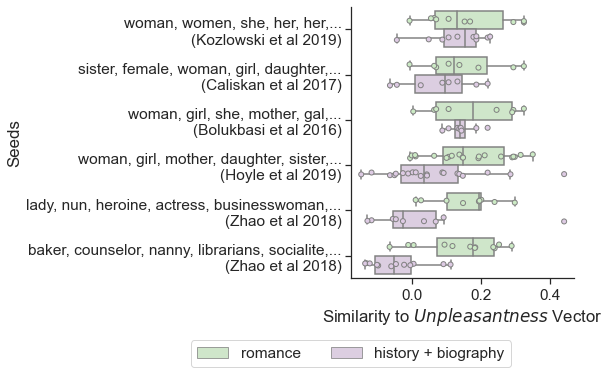

In [109]:
order = ['woman, women, she, her, her,...\n(Kozlowski et al 2019)',
         'sister, female, woman, girl, daughter,...\n(Caliskan et al 2017)',
         'woman, girl, she, mother, gal,...\n(Bolukbasi et al 2016)',
         'woman, girl, mother, daughter, sister,...\n(Hoyle et al 2019)',
         'lady, nun, heroine, actress, businesswoman,...\n(Zhao et al 2018)',
         'baker, counselor, nanny, librarians, socialite,...\n(Zhao et al 2018)']

fig, ax = plt.subplots(figsize=(4, 5))
sns.set(style='ticks', font_scale=1.4)

sns.boxplot(data=df_to_plot[df_to_plot['Label'] == 'female'],
            x='Similarity Unpleasant',
            y='Seeds',
            hue='Test',
            palette=sns.set_palette(sns.color_palette(['#ccebc5', '#decbe4'])),
            hue_order=['romance', 'history + biography'],
            showfliers=False,
            ax=ax,
            order=order)
sns.stripplot(data=df_to_plot[df_to_plot['Label'] == 'female'],
              x='Similarity Unpleasant',
              y='Seeds',
              hue='Test',
              jitter=True,
              palette=sns.set_palette(sns.color_palette(['#ccebc5', '#decbe4'])),
              hue_order=['romance', 'history + biography'],
              split=True,
              linewidth=1,
              edgecolor='gray',
              ax=ax,
              order=order)

sns.despine(ax=ax)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], loc='upper center', bbox_to_anchor=(0, -0.2), ncol=2)

plt.xlabel(r'Similarity to $\it{Unpleasantness}$ Vector')

# plt.savefig(plots_directory_path + '/boxplot.goodreads.gender.comparison.combined.pdf', bbox_inches='tight')